# Importing libraries

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.optimizers import Adam 
import itertools
from tensorflow.keras.optimizers import RMSprop, Adagrad, SGD, Adam
import keras
from keras.datasets import fashion_mnist
from keras import layers
from keras.models import Model
from tensorflow.keras.layers import Dropout
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.decomposition import PCA

# Importing dataset

In [92]:
drive.mount('/content/gdrive')
dataset1 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML/Final Project/Audio_Dataset.csv')
dataset2 = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/ML/Final Project/dataV2.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [93]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

def ROC(model, x_train, y_train, x_test, y_test, binary = False):
  visualizer = ROCAUC(model, binary = binary)
  visualizer.fit(x_train, y_train)
  visualizer.score(x_test, y_test) 
  visualizer.show() 

# Cleaning the dataset

In [94]:
voice_names_str = dataset1.song_name.values
X_total = dataset1.iloc[:, 1:].values
emotions = dataset2.emotionID.values
gender = dataset2.sex.values
voice_names_total = np.array([int(x[:-4]) for x in voice_names_str])
voice_id = dataset2['voice id'].values
X = []
voice_names = []
for i, name in enumerate(voice_names_total):
  if name in voice_id:
    X.append(X_total[i, :])
    voice_names.append(name)

X = np.array(X)
voice_names = np.array(voice_names)


y_emotions = []
y_gender_str = []
for i, name in enumerate(voice_names):
  y_emotions.append(emotions[np.where(voice_id == name)][0])
  y_gender_str.append(gender[np.where(voice_id == name)][0].lower())


y_emotions = np.array(y_emotions)

y_gender_str = np.array(y_gender_str)
y_gender = np.zeros(y_gender_str.shape)
y_gender[y_gender_str == 'f'] = 1

idx_to_delete = np.where(y_emotions > 4)
X = np.delete(X, idx_to_delete, axis = 0)
y_emotions = np.delete(y_emotions, idx_to_delete, axis = 0)
y_gender = np.delete(y_gender, idx_to_delete, axis = 0)

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X)
X = imputer.transform(X)

# Classifying emotions

In [95]:
X_train, X_test, y_emotions_train, y_emotions_test = train_test_split(X, y_emotions, test_size = 0.3)

In [96]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Training SVM classifier

In [97]:
best_acc, best_C = 0, 1
acc_list = []
best_svm_classifier = SVC(C = 0.01)
C = [0.1, 1, 10, 100]
for c in C:
  classifier = SVC(C = c)
  classifier.fit(X_train, y_emotions_train)
  y_emotions_pred1 = classifier.predict(X_test)
  curr_acc = accuracy_score(y_emotions_test, y_emotions_pred1)
  if curr_acc > best_acc:
    best_svm_classifier = classifier
    y_emotions_pred = y_emotions_pred1
    best_acc = curr_acc
    best_C = c

Best accuracy for svm classifer is 0.64 for C = 10


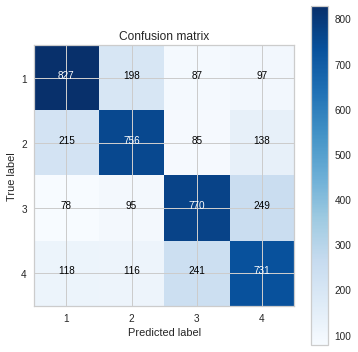

In [98]:
print('Best accuracy for svm classifer is {:.2f} for C = {}'.format(best_acc, best_C))
confusion_mtx = confusion_matrix(y_emotions_test, y_emotions_pred)
classes = np.unique(y_emotions_test)
plot_confusion_matrix(confusion_mtx, classes)

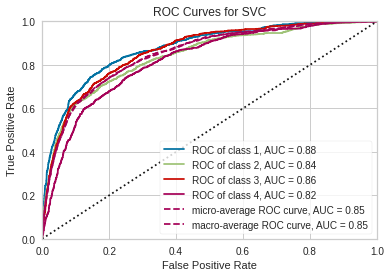

In [99]:
ROC(best_svm_classifier, X_train, y_emotions_train, X_test, y_emotions_test)

## Training KNN classifier

In [100]:
K = [3, 5, 7, 11]
best_acc, best_k = 0, 1
best_knn_classifier = KNeighborsClassifier(n_neighbors = 11)
acc_list = []
for k in K:
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(X_train, y_emotions_train)
  y_emotions_pred1 = classifier.predict(X_test)
  curr_acc = accuracy_score(y_emotions_test, y_emotions_pred1)
  if curr_acc > best_acc:
    y_emotions_pred = y_emotions_pred1
    best_acc = curr_acc
    best_knn_neighbors = classifier
    best_k = k

Best accuracy for KNN classifer is 0.60 for k = 5


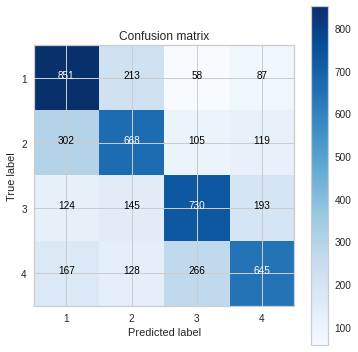

In [101]:
print('Best accuracy for KNN classifer is {:.2f} for k = {}'.format(best_acc, best_k))
confusion_mtx = confusion_matrix(y_emotions_test, y_emotions_pred)
classes = np.unique(y_emotions_test)
plot_confusion_matrix(confusion_mtx, classes)

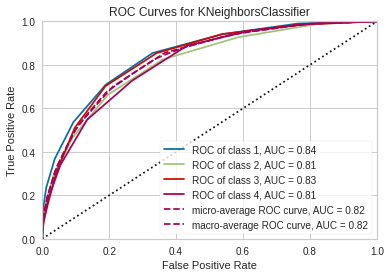

In [102]:
ROC(best_knn_classifier, X_train, y_emotions_train, X_test, y_emotions_test)

## Training MLP classifier

In [103]:
X_train_mlp, X_valid_mlp, y_emotions_train_mlp, y_emotions_valid_mlp = train_test_split(X_train, y_emotions_train, test_size = 0.15)

In [104]:
Y_train_mlp = np_utils.to_categorical(y_emotions_train_mlp - 1)
Y_test_mlp = np_utils.to_categorical(y_emotions_test - 1)
Y_valid_mlp = np_utils.to_categorical(y_emotions_valid_mlp - 1)

In [105]:
inputs = layers.Input(shape = (X_train.shape[1], ))
hidden_1 = layers.Dense(128, activation = 'relu')(inputs)
dropout = layers.Dropout(rate = 0.2)(hidden_1)
hidden_2 = layers.Dense(64, activation = 'relu')(dropout)
outputs = layers.Dense(4, activation = 'softmax')(hidden_2)
model = Model(inputs, outputs)
model.summary()
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
history = model.fit(X_train_mlp, Y_train_mlp, batch_size = 64, epochs = 100, validation_data = (X_valid_mlp, Y_valid_mlp))

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 101)]             0         
                                                                 
 dense_18 (Dense)            (None, 128)               13056     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 4)                 260       
                                                                 
Total params: 21,572
Trainable params: 21,572
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
149/149 [==============================] - 

151/151 [==============================] - 0s 2ms/step - loss: 1.4198 - accuracy: 0.5657
Test Loss = 1.420
Test Accuracy = 0.566


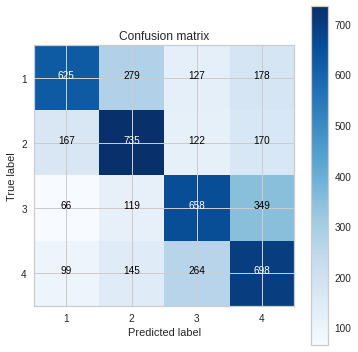

In [106]:
test_val = model.evaluate(X_test, Y_test_mlp)
print('Test Loss = {:.3f}'.format(test_val[0]))
print('Test Accuracy = {:.3f}'.format(test_val[1]))
y_emotions_pred = model.predict(X_test)
y_emotions_pred = np.argmax(y_emotions_pred, axis = 1) + 1

confusion_mtx = confusion_matrix(y_emotions_test, y_emotions_pred)
classes = np.unique(y_emotions_test)
plot_confusion_matrix(confusion_mtx, classes)

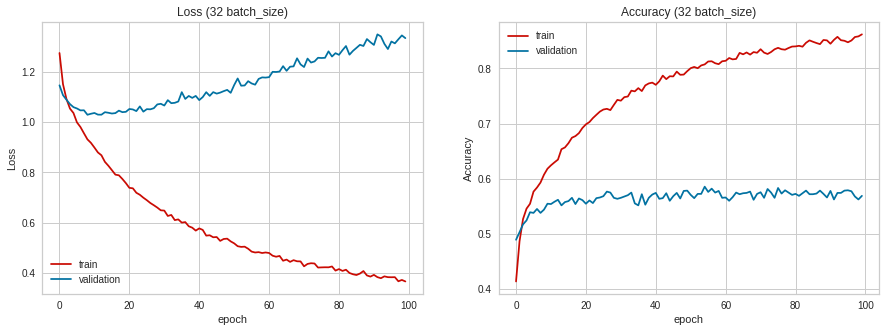

In [107]:
fig, (ax11, ax12) = plt.subplots(1, 2, figsize = (15, 5))


ax11.plot(history.history['loss'], 'r')
ax11.plot(history.history['val_loss'], 'b')
ax11.set_title('Loss (32 batch_size)')
ax11.set_xlabel('epoch')
ax11.set_ylabel('Loss')
ax11.legend(['train', 'validation'])


ax12.plot(history.history['accuracy'], 'r')
ax12.plot(history.history['val_accuracy'], 'b')
ax12.set_title('Accuracy (32 batch_size)')
ax12.set_xlabel('epoch')
ax12.set_ylabel('Accuracy')
ax12.legend(['train', 'validation'])

# Classifying gender

In [108]:
X_train, X_test, y_gender_train, y_gender_test = train_test_split(X, y_gender, test_size = 0.3)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Training SVM classifier

In [109]:
best_acc, best_C = 0, 0
acc_list = []
best_svm_classifier = SVC(C = 0.001)
C = [0.1, 1, 10, 100]
for c in C:
  classifier = SVC(C = c)
  classifier.fit(X_train, y_gender_train)
  y_gender_pred1 = classifier.predict(X_test)
  curr_acc = accuracy_score(y_gender_test, y_gender_pred1)
  if curr_acc > best_acc:
    y_gender_pred = y_gender_pred1
    best_acc = curr_acc
    best_svm_classifier = classifier
    best_C = c

Best accuracy for svm classifer is 0.97 for C = 100


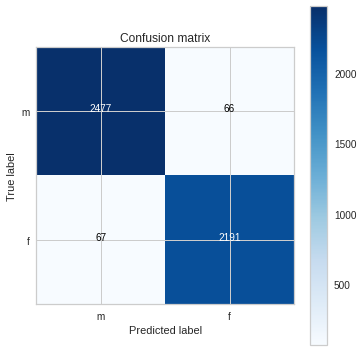

In [110]:
print('Best accuracy for svm classifer is {:.2f} for C = {}'.format(best_acc, best_C))
confusion_mtx = confusion_matrix(y_gender_test, y_gender_pred)
classes = ['m', 'f']
plot_confusion_matrix(confusion_mtx, classes)

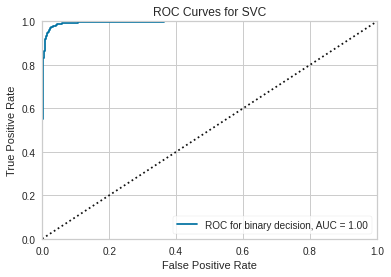

In [111]:
ROC(best_svm_classifier, X_train, y_gender_train, X_test, y_gender_test, binary = True)

## Training KNN classifier

In [112]:
K = [3, 5, 7, 9, 11]
best_acc, best_k = 0, 1
acc_list = []
best_knn_classifier = KNeighborsClassifier(n_neighbors = 11)
for k in K:
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(X_train, y_gender_train)
  y_gender_pred1 = classifier.predict(X_test)
  curr_acc = accuracy_score(y_gender_test, y_gender_pred1)
  if curr_acc > best_acc:
    y_gender_pred = y_gender_pred1
    best_acc = curr_acc
    best_k = k
    best_knn_classifier = classifier

Best accuracy for KNN classifer is 0.97 for k = 3


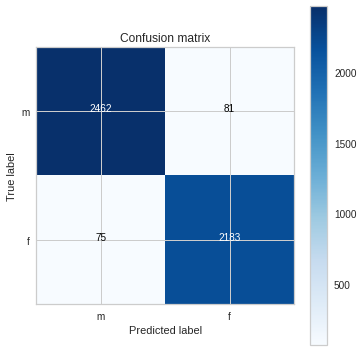

In [113]:
print('Best accuracy for KNN classifer is {:.2f} for k = {}'.format(best_acc, best_k))
confusion_mtx = confusion_matrix(y_gender_test, y_gender_pred)
classes = ['m', 'f']
plot_confusion_matrix(confusion_mtx, classes)

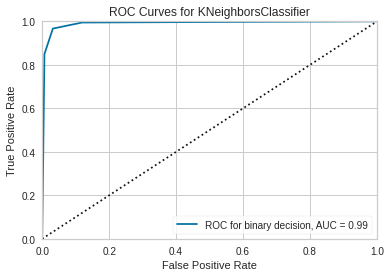

In [114]:
ROC(best_knn_classifier, X_train, y_gender_train, X_test, y_gender_test, binary = True)

## Training MLP classifier

In [115]:
X_train_mlp, X_valid_mlp, y_gender_train_mlp, y_gender_valid_mlp = train_test_split(X_train, y_gender_train, test_size = 0.15)

In [116]:
inputs = layers.Input(shape = (X_train.shape[1], ))
hidden_1 = layers.Dense(64, activation = 'relu')(inputs)
dropout = layers.Dropout(rate = 0.2)(hidden_1)
hidden_2 = layers.Dense(32, activation = 'relu')(dropout)
outputs = layers.Dense(1, activation = 'sigmoid')(hidden_2)
model = Model(inputs, outputs)
model.summary()
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
history = model.fit(X_train_mlp, y_gender_train_mlp, batch_size = 64, epochs = 100, validation_data = (X_valid_mlp, y_gender_valid_mlp))

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 101)]             0         
                                                                 
 dense_21 (Dense)            (None, 64)                6528      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
149/149 [==============================] - 1s

151/151 [==============================] - 0s 2ms/step - loss: 0.1660 - accuracy: 0.9525
Test Loss = 0.166
Test Accuracy = 0.953


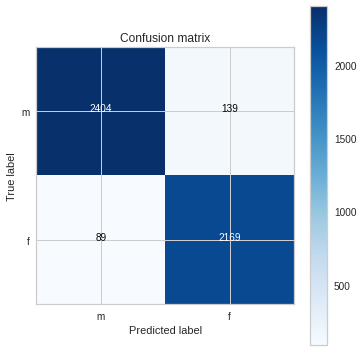

In [117]:
test_val = model.evaluate(X_test, y_gender_test)
print('Test Loss = {:.3f}'.format(test_val[0]))
print('Test Accuracy = {:.3f}'.format(test_val[1]))
y_gender_pred = model.predict(X_test)
y_gender_pred[y_gender_pred > 0.5] = 1
y_gender_pred[y_gender_pred <= 0.5] = 0
confusion_mtx = confusion_matrix(y_gender_test, y_gender_pred)
classes = ['m', 'f']
plot_confusion_matrix(confusion_mtx, classes)

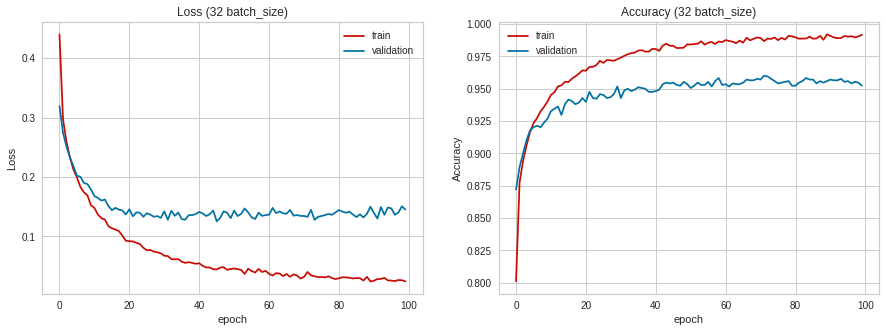

In [118]:
fig, (ax11, ax12) = plt.subplots(1, 2, figsize = (15, 5))


ax11.plot(history.history['loss'], 'r')
ax11.plot(history.history['val_loss'], 'b')
ax11.set_title('Loss (32 batch_size)')
ax11.set_xlabel('epoch')
ax11.set_ylabel('Loss')
ax11.legend(['train', 'validation'])


ax12.plot(history.history['accuracy'], 'r')
ax12.plot(history.history['val_accuracy'], 'b')
ax12.set_title('Accuracy (32 batch_size)')
ax12.set_xlabel('epoch')
ax12.set_ylabel('Accuracy')
ax12.legend(['train', 'validation'])

# Classifying using PCA to reduce data's dimension


In [119]:
X_train, X_test, y_emotions_train, y_emotions_test = train_test_split(X, y_emotions, test_size = 0.3)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [120]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [121]:
print('Number of dimension kept = {}'.format(X_train_reduced.shape[1]))

Number of dimension kept = 59


# Classifying emotions using dimensionally-reduced data

## Training SVM classifier

In [122]:
best_acc, best_C = 0, 1
acc_list = []
best_svm_classifier = SVC(C = 0.01)
C = [0.1, 1, 10, 100]
for c in C:
  classifier = SVC(C = c)
  classifier.fit(X_train_reduced, y_emotions_train)
  y_emotions_pred1 = classifier.predict(X_test_reduced)
  curr_acc = accuracy_score(y_emotions_test, y_emotions_pred1)
  if curr_acc > best_acc:
    best_svm_classifier = classifier
    y_emotions_pred = y_emotions_pred1
    best_acc = curr_acc
    best_C = c

Best accuracy for svm classifer is 0.61 for C = 10


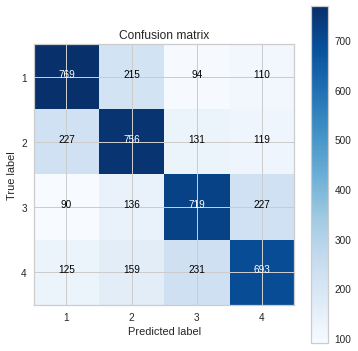

In [123]:
print('Best accuracy for svm classifer is {:.2f} for C = {}'.format(best_acc, best_C))
confusion_mtx = confusion_matrix(y_emotions_test, y_emotions_pred)
classes = np.unique(y_emotions_test)
plot_confusion_matrix(confusion_mtx, classes)

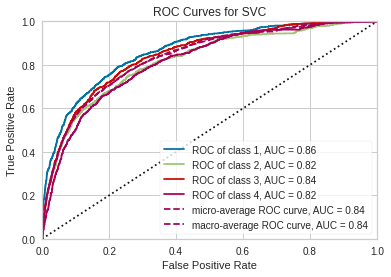

In [124]:
ROC(best_svm_classifier, X_train_reduced, y_emotions_train, X_test_reduced, y_emotions_test)

## Training KNN classifier

In [125]:
K = [3, 5, 7, 11]
best_acc, best_k = 0, 1
best_knn_classifier = KNeighborsClassifier(n_neighbors = 11)
acc_list = []
for k in K:
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(X_train_reduced, y_emotions_train)
  y_emotions_pred1 = classifier.predict(X_test_reduced)
  curr_acc = accuracy_score(y_emotions_test, y_emotions_pred1)
  if curr_acc > best_acc:
    y_emotions_pred = y_emotions_pred1
    best_acc = curr_acc
    best_knn_neighbors = classifier
    best_k = k

Best accuracy for KNN classifer is 0.59 for k = 7


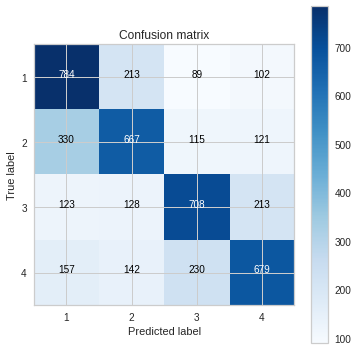

In [126]:
print('Best accuracy for KNN classifer is {:.2f} for k = {}'.format(best_acc, best_k))
confusion_mtx = confusion_matrix(y_emotions_test, y_emotions_pred)
classes = np.unique(y_emotions_test)
plot_confusion_matrix(confusion_mtx, classes)

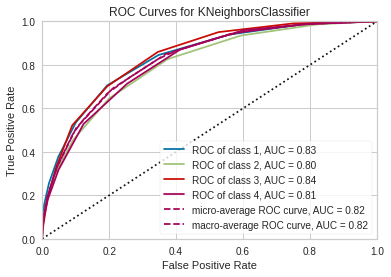

In [127]:
ROC(best_knn_classifier, X_train_reduced, y_emotions_train, X_test_reduced, y_emotions_test)

## Training MLP classifier

In [128]:
X_train_mlp, X_valid_mlp, y_emotions_train_mlp, y_emotions_valid_mlp = train_test_split(X_train_reduced, y_emotions_train, test_size = 0.15)

In [129]:
Y_train_mlp = np_utils.to_categorical(y_emotions_train_mlp - 1)
Y_test_mlp = np_utils.to_categorical(y_emotions_test - 1)
Y_valid_mlp = np_utils.to_categorical(y_emotions_valid_mlp - 1)

In [130]:
inputs = layers.Input(shape = (X_train_reduced.shape[1], ))
hidden_1 = layers.Dense(128, activation = 'relu')(inputs)
dropout = layers.Dropout(rate = 0.2)(hidden_1)
hidden_2 = layers.Dense(64, activation = 'relu')(dropout)
outputs = layers.Dense(4, activation = 'softmax')(hidden_2)
model = Model(inputs, outputs)
model.summary()
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
history = model.fit(X_train_mlp, Y_train_mlp, batch_size = 64, epochs = 100, validation_data = (X_valid_mlp, Y_valid_mlp))

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 59)]              0         
                                                                 
 dense_24 (Dense)            (None, 128)               7680      
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                8256      
                                                                 
 dense_26 (Dense)            (None, 4)                 260       
                                                                 
Total params: 16,196
Trainable params: 16,196
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
149/149 [==============================] - 

151/151 [==============================] - 0s 2ms/step - loss: 1.3509 - accuracy: 0.5413
Test Loss = 1.351
Test Accuracy = 0.541


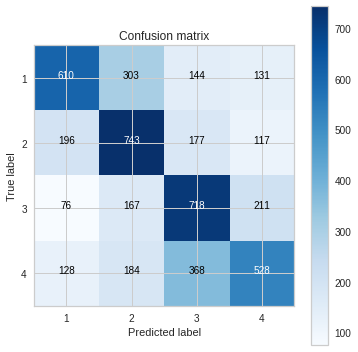

In [131]:
test_val = model.evaluate(X_test_reduced, Y_test_mlp)
print('Test Loss = {:.3f}'.format(test_val[0]))
print('Test Accuracy = {:.3f}'.format(test_val[1]))
y_emotions_pred = model.predict(X_test_reduced)
y_emotions_pred = np.argmax(y_emotions_pred, axis = 1) + 1

confusion_mtx = confusion_matrix(y_emotions_test, y_emotions_pred)
classes = np.unique(y_emotions_test)
plot_confusion_matrix(confusion_mtx, classes)

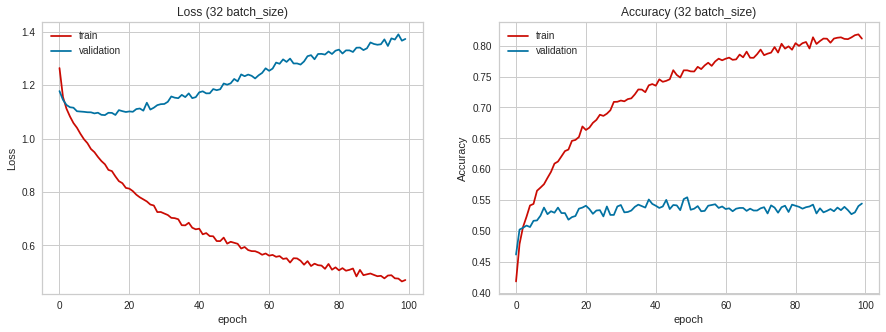

In [132]:
fig, (ax11, ax12) = plt.subplots(1, 2, figsize = (15, 5))


ax11.plot(history.history['loss'], 'r')
ax11.plot(history.history['val_loss'], 'b')
ax11.set_title('Loss (32 batch_size)')
ax11.set_xlabel('epoch')
ax11.set_ylabel('Loss')
ax11.legend(['train', 'validation'])


ax12.plot(history.history['accuracy'], 'r')
ax12.plot(history.history['val_accuracy'], 'b')
ax12.set_title('Accuracy (32 batch_size)')
ax12.set_xlabel('epoch')
ax12.set_ylabel('Accuracy')
ax12.legend(['train', 'validation'])

# Classifying gender with using dimensionally-reduced data

In [133]:
X_train, X_test, y_gender_train, y_gender_test = train_test_split(X, y_gender, test_size = 0.3)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [134]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)
X_train_reduced = pca.transform(X_train)
X_test_reduced = pca.transform(X_test)

In [135]:
print('Number of dimension kept = {}'.format(X_train_reduced.shape[1]))

Number of dimension kept = 59


## Training SVM classifier

In [136]:
best_acc, best_C = 0, 0
acc_list = []
best_svm_classifier = SVC(C = 0.001)
C = [0.1, 1, 10, 100]
for c in C:
  classifier = SVC(C = c)
  classifier.fit(X_train_reduced, y_gender_train)
  y_gender_pred1 = classifier.predict(X_test_reduced)
  curr_acc = accuracy_score(y_gender_test, y_gender_pred1)
  if curr_acc > best_acc:
    y_gender_pred = y_gender_pred1
    best_acc = curr_acc
    best_svm_classifier = classifier
    best_C = c

Best accuracy for svm classifer is 0.97 for C = 100


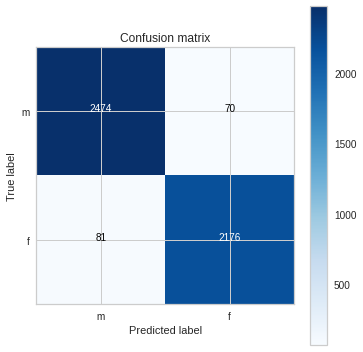

In [137]:
print('Best accuracy for svm classifer is {:.2f} for C = {}'.format(best_acc, best_C))
confusion_mtx = confusion_matrix(y_gender_test, y_gender_pred)
classes = ['m', 'f']
plot_confusion_matrix(confusion_mtx, classes)

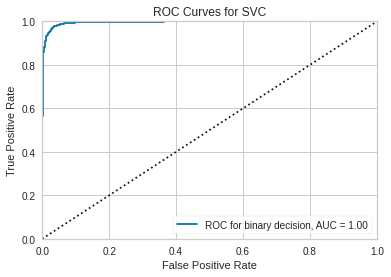

In [138]:
ROC(best_svm_classifier, X_train_reduced, y_gender_train, X_test_reduced, y_gender_test, binary = True)

## Training KNN classifier

In [139]:
K = [3, 5, 7, 9, 11]
best_acc, best_k = 0, 1
acc_list = []
best_knn_classifier = KNeighborsClassifier(n_neighbors = 11)
for k in K:
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(X_train_reduced, y_gender_train)
  y_gender_pred1 = classifier.predict(X_test_reduced)
  curr_acc = accuracy_score(y_gender_test, y_gender_pred1)
  if curr_acc > best_acc:
    y_gender_pred = y_gender_pred1
    best_acc = curr_acc
    best_k = k
    best_knn_classifier = classifier

Best accuracy for KNN classifer is 0.97 for k = 5


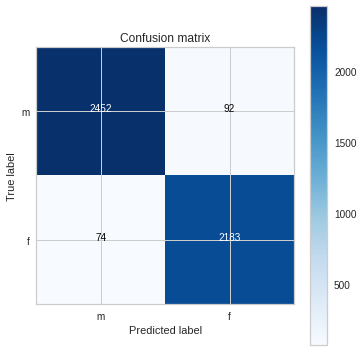

In [140]:
print('Best accuracy for KNN classifer is {:.2f} for k = {}'.format(best_acc, best_k))
confusion_mtx = confusion_matrix(y_gender_test, y_gender_pred)
classes = ['m', 'f']
plot_confusion_matrix(confusion_mtx, classes)

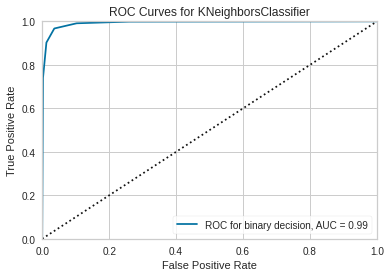

In [141]:
ROC(best_knn_classifier, X_train_reduced, y_gender_train, X_test_reduced, y_gender_test, binary = True)

## Training MLP classifier

In [142]:
X_train_mlp, X_valid_mlp, y_gender_train_mlp, y_gender_valid_mlp = train_test_split(X_train_reduced, y_gender_train, test_size = 0.15)

In [143]:
inputs = layers.Input(shape = (X_train_reduced.shape[1], ))
hidden_1 = layers.Dense(64, activation = 'relu')(inputs)
dropout = layers.Dropout(rate = 0.2)(hidden_1)
hidden_2 = layers.Dense(32, activation = 'relu')(dropout)
outputs = layers.Dense(1, activation = 'sigmoid')(hidden_2)
model = Model(inputs, outputs)
model.summary()
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
history = model.fit(X_train_mlp, y_gender_train_mlp, batch_size = 64, epochs = 100, validation_data = (X_valid_mlp, y_gender_valid_mlp))

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 59)]              0         
                                                                 
 dense_27 (Dense)            (None, 64)                3840      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
149/149 [==============================] - 2s

151/151 [==============================] - 0s 2ms/step - loss: 0.1642 - accuracy: 0.9508
Test Loss = 0.164
Test Accuracy = 0.951


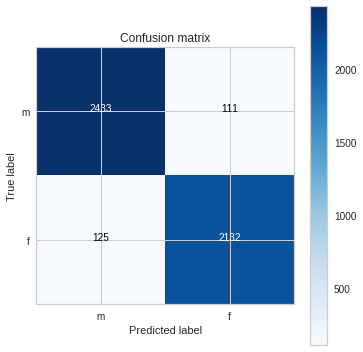

In [144]:
test_val = model.evaluate(X_test_reduced, y_gender_test)
print('Test Loss = {:.3f}'.format(test_val[0]))
print('Test Accuracy = {:.3f}'.format(test_val[1]))
y_gender_pred = model.predict(X_test_reduced)
y_gender_pred[y_gender_pred > 0.5] = 1
y_gender_pred[y_gender_pred <= 0.5] = 0
confusion_mtx = confusion_matrix(y_gender_test, y_gender_pred)
classes = ['m', 'f']
plot_confusion_matrix(confusion_mtx, classes)

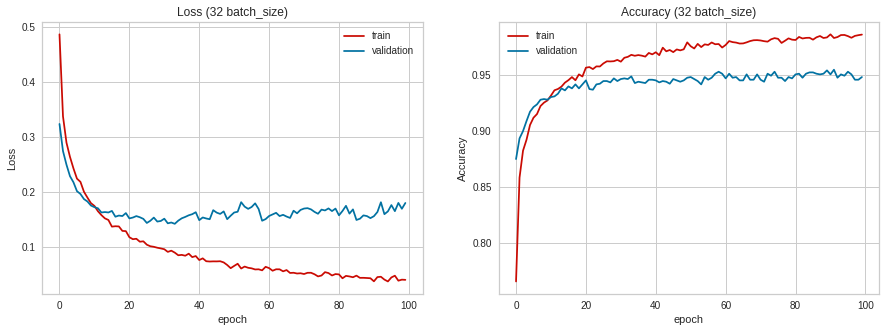

In [145]:
fig, (ax11, ax12) = plt.subplots(1, 2, figsize = (15, 5))


ax11.plot(history.history['loss'], 'r')
ax11.plot(history.history['val_loss'], 'b')
ax11.set_title('Loss (32 batch_size)')
ax11.set_xlabel('epoch')
ax11.set_ylabel('Loss')
ax11.legend(['train', 'validation'])


ax12.plot(history.history['accuracy'], 'r')
ax12.plot(history.history['val_accuracy'], 'b')
ax12.set_title('Accuracy (32 batch_size)')
ax12.set_xlabel('epoch')
ax12.set_ylabel('Accuracy')
ax12.legend(['train', 'validation'])